# **Targeted Sentiment Analysis**

This document introduces one of the tasks for the Spring 2020 Home Exam for
IN5550: Targeted Sentiment Analysis for Norwegian. For general instructions
regarding the home exam, see the information at the semester page for the
course:

https://www.uio.no/studier/emner/matnat/ifi/IN5550/v20/exam.html


## The task in short

Fine-grained *Sentiment Analysis* (SA), sometimes referred to as *Opinion Analysis/Mining*, 
is the task of identifying opinions in text and analyzing them in terms of their polar expressions, targets, and holders. 
In this task we will focus on targeted SA, i.e. the identification of the target of opinion along with the
polarity with which it is associated in the text (positive/negative). 

In the example below, for instance, the target of the opinion is disken *the disk* and it
is ascribed a positive polarity by the surrounding context.

*Denne diskenP OS er svært stillegående*

*This disk is very quiet-going*

**This disk runs very quietly**

All data and pre-code needed to work on this assignment is available from:

https://github.uio.no/in5550/2020/tree/master/exam/targeted_sa


## Data

We will be working with the recently released NoReCfine, a dataset for finegrained sentiment analysis in Norwegian. 
The texts in the dataset have been annotated with respect to polar expressions, targets and holders of opinion but
we will here be focusing on identification of targets and their polarity only.
The underlying texts are taken from a corpus of professionally authored reviews
from multiple news-sources and across a wide variety of domains, including
literature, games, music, products, movies and more. Table 1 presents the
dataset and its annotated targets. The dataset is distributed with pre-defined
train, development and test splits.


|            | Train | Dev  | Test | Total | Avg length |
|------------|-------|------|------|-------|------------|
| **Sentiments** | 6145  | 1184 | 930  | 8259  | 16.8       |
| **Targets**    | 4458  | 832  | 702  | 5999  | 2.0        |


## Data format
The task respository contains data that has been converted from the native
json-format of NoReCfineto the conll-format assumed for this task: each line is
a token and label, separated by a tab, and sentences are separated by a new
line. The labels are BIO + polarity (Positive, Negative) for a total of 5 labels
(B-targ-Positive, I-targ-Positive, B-targ-Negative, I-targ-Negative, O).


| sent_id            | 501595-13-04    |
|--------------------|-----------------|
| Munken             | B-targ-Positive |
| Bistro             | I-targ-Positive |
| er                 | O               |
| en                 | O               |
| hyggelig           | O               |
| nabolagsrestaurant | O               |
| for                | O               |
| hverdagslige       | O               |
| og                 | O               |
| uformelle          | O               |
| anledninger        | O               |
| .                  | O               |


## Modeling
The main objective of the home exam is to train a neural system to perform
targeted sentiment analysis for Norwegian text. In order to complete the task
you should follow these steps:

### Baseline model
You can base your work on PyTorch pre-code for a baseline
model and evaluate this on the development and test data. This is a simple
bi-LSTM model that leaves room for a number of possible improvements.

### Experimental evaluation
You should experimentally evaluate the effect of at
least three different changes to your basic system. Some possible directions
for further experimentation are provided below, but you are also free to
come up with experimental directions of your own. Evaluation of changes
to your systems should be performed on the development set.

### Held-out testing 
The best configuration of your system following experimentation should be evaluated on the test set.


## Write a report
Your experiments should be described in a report following
the exam template detailing your experiments and findings.

## Evaluation
The models will be evaluated on two different metrics: proportional F1and
binary F1. Binary Overlap counts any overlapping predicted and gold span as
correct. Proportional Overlap instead assigns precision as the ratio of overlap
with the predicted span and recall as the ratio of overlap with the gold span,
which reduces to token-level F1. Proportional F1is therefore a stricter measure
than Binary F1. You will have scripts available to calculate these scores.

## Possible directions for experimentation
You can explore a number of directions we suggest below, but you’re encouraged
to come up with other ideas for yourself.

* Experiment with alternative label encoding (e.g. BIOUL)
* Compare pipeline vs. joint prediction approaches.
* Impact of different architectures:
    * LSTM vs. GRU vs. Transformer
    * Include character-level information
    * Depth of model (2-layer, 3-layer, etc)
* Effect of using pretrained models (ELMo1, BERT2, or Multilingual Bert3)
* Perform a small error analysis (confusion matrix, the most common errors).


# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [2]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Then, let's load the dependencies:

In [3]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from torch.utils.data import DataLoader

# Data science
import spacy
import numpy as np
import time
import random

In [4]:
#Let's not forget to fix the seed for random generated numbers !
SEED = 2020 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **1. Baseline**

In [5]:
# SenTarget package
from baseline.dataset import Vocab, ConllDataset
from baseline.word2vec import Word2Vec
from baseline.utils import binary_analysis, proportional_analysis, get_analysis
from baseline.model import BiLSTM

# Progress Bar
from tqdm import tqdm

In [6]:
NUM_LAYERS = 1
HIDDEN_DIM = 100
BATCH_SIZE = 50
DROPOUT = 0.01
EMBEDDING_DIM = 100
EMBEDDINGS = "word2vec/model.txt" # Change to the path where you downloaded the `58.zip` vector file.
TRAIN_EMBEDDINGS = True
LEARNING_RATE = 0.01
EPOCHS = 2

### 1.1. Embeddings

In [7]:
# Get embeddings (CHANGE TO GLOVE OR FASTTEXT EMBEDDINGS)
embeddings = Word2Vec(EMBEDDINGS)
w2idx = embeddings._w2idx

In [8]:
embeddings._matrix.shape

(1182371, 100)

### 1.2. Vocabulary

In [9]:
# Create shared vocabulary for tasks
vocab = Vocab(train=True)

# Update with word2idx from pretrained embeddings so we don't lose them
# making sure to change them by two to avoid overwriting the PAD and UNK
# tokens at index 0 and 1
with_unk = {}
for word, idx in embeddings._w2idx.items():
    with_unk[word] = idx + 2
    
vocab.update(with_unk)

### 1.3. Datasets

In [10]:
# Import datasets
# This will update vocab with words not found in embeddings
dataset = ConllDataset(vocab)

train_iter = dataset.get_split("data/train.conll")
dev_iter = dataset.get_split("data/dev.conll")
test_iter = dataset.get_split("data/test.conll")

In [11]:
print("raws, words, targets, idxs")
test_iter[5]

raws, words, targets, idxs


(['Texas-baserte',
  'Retro',
  'Studios',
  'videreførte',
  'tradisjonen',
  'med',
  'å',
  'utvikle',
  'spillserien',
  'utenfor',
  'Nintendos',
  'egne',
  'studioer',
  'med',
  'Donkey',
  'Kong',
  'Country',
  'Return',
  'på',
  'Wii-konsollen',
  'i',
  '2010',
  '.'],
 tensor([1192028, 1192029, 1183207, 1192030,    6342,      16, 1182398,    2220,
           78093,     492, 1188063,     808,   42162,      16, 1192021, 1187209,
         1192022, 1192031, 1182380, 1192032,       5,     623,       3]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 5)

### 1.4. Embeddings update

In [12]:
# Create a new embedding matrix which includes the pretrained embeddings
# as well as new embeddings for PAD UNK and tokens not found in the
# pretrained embeddings.
diff = len(vocab) - embeddings.vocab_length - 2
PAD_UNK_embeddings = np.zeros((2, EMBEDDING_DIM))
new_embeddings = np.zeros((diff, EMBEDDING_DIM))
new_matrix = np.concatenate((PAD_UNK_embeddings,
                             embeddings._matrix,
                             new_embeddings))

### 1.5. Data Loader

In [13]:
# Set up the data iterators for the LSTM model. The batch size for the dev
# and test loader is set to 1 for the predict() and evaluate() methods
train_loader = DataLoader(train_iter,
                          batch_size = BATCH_SIZE,
                          collate_fn = train_iter.collate_fn,
                          shuffle = True)

dev_loader = DataLoader(dev_iter,
                        batch_size = 1,
                        collate_fn = dev_iter.collate_fn,
                        shuffle = False)

test_loader = DataLoader(test_iter,
                         batch_size = 1,
                         collate_fn = test_iter.collate_fn,
                         shuffle = False)

In [14]:
# Automatically determine whether to run on CPU or GPU
device = torch.device('cpu')

### 1.6. Model instance

In [15]:
model = BiLSTM(word2idx = vocab,
               embedding_matrix = new_matrix,
               embedding_dim = EMBEDDING_DIM,
               hidden_dim = HIDDEN_DIM,
               device = device,
               output_dim = 5,
               num_layers = NUM_LAYERS,
               word_dropout = DROPOUT,
               learning_rate = LEARNING_RATE,
               train_embeddings = TRAIN_EMBEDDINGS)

### 1.7. Training

In [16]:
model.fit(train_loader, dev_loader, epochs = EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [08:38<00:00,  4.36s/it]



Epoch 1 loss: 0.701
Dev


100%|██████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:21<00:00, 53.28it/s]


Binary results:
################################################################################

Target prec: 0.833
Target recall: 0.008
Target F1: 0.016

Proportional results:
################################################################################



  0%|                                                                                          | 0/119 [00:00<?, ?it/s]

Target prec: 0.667
Target recall: 0.003
Target F1: 0.006



  1%|▌                                                                                | 8/1151 [00:00<00:14, 79.25it/s]


Epoch 2 loss: 0.239
Dev


100%|██████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:17<00:00, 66.32it/s]


Binary results:
################################################################################

Target prec: 0.478
Target recall: 0.238
Target F1: 0.318

Proportional results:
################################################################################

Target prec: 0.338
Target recall: 0.140
Target F1: 0.198



### 1.8. Evaluation

In [17]:
binary_f1, propor_f1 = model.evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 895/895 [00:16<00:00, 54.08it/s]


Binary results:
################################################################################

Target prec: 0.473
Target recall: 0.203
Target F1: 0.284

Proportional results:
################################################################################

Target prec: 0.384
Target recall: 0.161
Target F1: 0.227



In [21]:
# For printing the predictions, we would prefer to see the actual labels,
# rather than the indices, so we create and index to label dictionary
# which the print_predictions method takes as input.

idx2label = {i: l for l, i in dataset.label2idx.items()}

model.print_predictions(test_loader,
                        outfile = "predictions.conll",
                        idx2label = idx2label)

100%|████████████████████████████████████████████████████████████████████████████████| 895/895 [00:12<00:00, 73.94it/s]


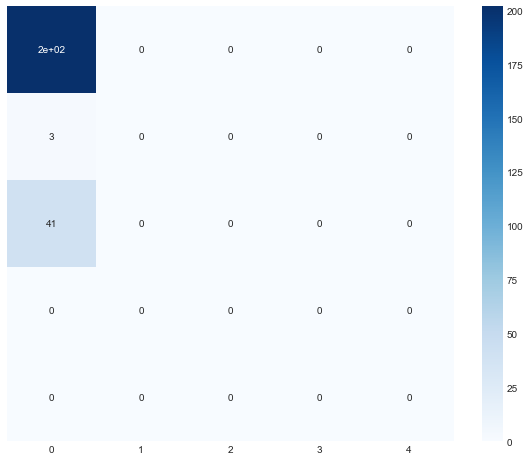

In [20]:
model.confusion.plot(labels=[1, 2, 3, 4, 5])